In [2]:
import numpy as onp

from uf3.data import composition
from uf3.representation import bspline
from uf3.regression import least_squares
from uf3.forcefield import calculator

from uf3.jax.potentials import uf3_neighbor
from uf3.util.jax_utils import from_ase_calculator

import ase

import jax.numpy as jnp
from jax import random
from jax import jit, grad, vmap, value_and_grad
from jax import lax
from jax import ops

from jax.config import config
config.update("jax_enable_x64", True)

from jax_md import space, smap, energy, minimize, quantity, simulate, partition, util

from functools import partial
import time
from typing import List

f32 = jnp.float32
f64 = jnp.float64
Array = jnp.ndarray

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

def format_plot(x, y):  
  plt.grid(True)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 0.7)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

def plot_system(R,box_size,species=None,ms=20):
  R_plt = onp.array(R)

  if(species is None):
    plt.plot(R_plt[:, 0], R_plt[:, 1], 'o', markersize=ms)
  else:
    for ii in range(jnp.amax(species)+1):
      Rtemp = R_plt[species==ii]
      plt.plot(Rtemp[:, 0], Rtemp[:, 1], 'o', markersize=ms)

  plt.xlim([0, box_size])
  plt.ylim([0, box_size])
  plt.xticks([], [])
  plt.yticks([], [])

  finalize_plot((1,1))

  
key = random.PRNGKey(0)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Replicating an UF3 2-body potential

## Defining the system

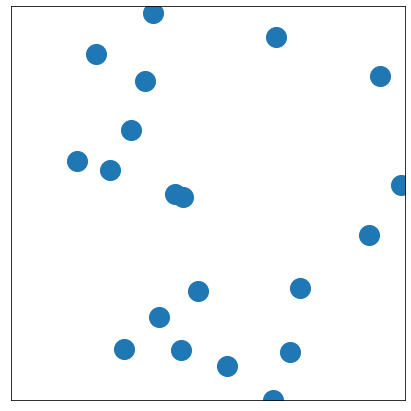

In [3]:
N = 20
dimension = 3
box_size = 12.0

key, split = random.split(key)
R = random.uniform(split, (N,dimension), minval=0.0, maxval=box_size, dtype=f64) 

plot_system(R,box_size)

In [4]:
box = jnp.eye(dimension) * box_size
displacement, shift = space.periodic_general(box, fractional_coordinates=False)

## UF2

In [5]:
# ASE UF2 potential - one element
element_list = ['W']
degree = 2
chemical_system = composition.ChemicalSystem(element_list=element_list,
                                             degree=degree)
r_min_map = {('W', 'W'): 1.5,
            }
r_max_map = {('W', 'W'): 5.5,
            }
resolution_map = {('W', 'W'): 25,
                 }
trailing_trim = 3
bspline_config = bspline.BSplineBasis(chemical_system,
                                      r_min_map=r_min_map,
                                      r_max_map=r_max_map,
                                      resolution_map=resolution_map,
                                      trailing_trim=trailing_trim)
model = least_squares.WeightedLinearModel(bspline_config)

model.load(filename="../../tungsten_extxyz/model_pair.json")
ASE_uf2_tungsten = calculator.UFCalculator(model)

In [6]:
jax_uf2_params = from_ase_calculator(ASE_uf2_tungsten)

In [9]:
from uf3.jax.potentials import uf3_neighbor

In [29]:
knots = [jnp.pad(jnp.linspace(1.0,5.5,25),(3,3),"edge")]
coefficients = [1.0, jnp.zeros(len(knots[0])-4)]

In [12]:
knots

[DeviceArray([1.    , 1.    , 1.    , 1.    , 1.1875, 1.375 , 1.5625,
              1.75  , 1.9375, 2.125 , 2.3125, 2.5   , 2.6875, 2.875 ,
              3.0625, 3.25  , 3.4375, 3.625 , 3.8125, 4.    , 4.1875,
              4.375 , 4.5625, 4.75  , 4.9375, 5.125 , 5.3125, 5.5   ,
              5.5   , 5.5   , 5.5   ], dtype=float64)]

In [30]:
uf2_nf, uf2_energy = uf3_neighbor(displacement, box, knots=[knots], coefficients=coefficients, cutoff=5.5)

In [31]:
nbrs_uf2 = uf2_nf.allocate(R, extra_capacity=10)

In [32]:
uf2_energy = jit(uf2_energy)
uf2_energy(R, nbrs_uf2)

DeviceArray(20., dtype=float64)

## Loss function

In [33]:
from uf3.jax.physical import stress_neighborlist_fn
from uf3.regression.regularize import get_regularizer_matrix

In [34]:
def train_energy_fn(R, energy_fn, neighborlist_fn):
    nbrs = neighborlist_fn.allocate(R, extra_capacity=15)
    @jit
    def fn(params, R):
        _neighbor = neighborlist_fn.update(R, nbrs)
        return energy_fn(R, _neighbor, coefficients=params)

    return fn


def train_stress_fn(R, energy_fn, neighborlist_fn):
    nbrs = neighborlist_fn.allocate(R, extra_capacity=10)
    stress = stress_neighborlist_fn(energy_fn, box)
    @jit
    def fn(params, R):
        _neighbor = neighborlist_fn.update(R, nbrs)
        return stress(R, _neighbor, coefficients=params)

    return fn

train_energy_uf2 = train_energy_fn(R, uf2_energy, uf2_nf)
train_stress_uf2 = train_stress_fn(R, uf2_energy, uf2_nf)

# Vectorize over states, not parameters.
vectorized_energy_uf2 = vmap(train_energy_uf2, (None, 0))

grad_uf2 = grad(train_energy_uf2, argnums=1)
force_uf2 = lambda params, R, **kwargs: -grad_uf2(params, R)
vectorized_force_uf2 = vmap(force_uf2, (None, 0))

vectorized_stress_uf2 = vmap(train_stress_uf2, (None, 0))


In [35]:
def regularize(coefficients, ridge=0.0, curvature=1.0):
    return jnp.sum(
        jnp.einsum(
            "ij,j->i",
            get_regularizer_matrix(len(coefficients), ridge=ridge, curvature=curvature),
            coefficients,
        )
        ** 2
    )



In [36]:
get_regularizer_matrix(5, ridge=1, curvature=1)

array([[ 2., -1.,  0.,  0.,  0.],
       [-1.,  3., -1.,  0.,  0.],
       [ 0., -1.,  3., -1.,  0.],
       [ 0.,  0., -1.,  3., -1.],
       [ 0.,  0.,  0., -1.,  2.]])

In [37]:
@jit
def energy_loss(params, R, energy_targets):
    return jnp.mean((vectorized_energy_uf2(params, R) - energy_targets) ** 2)


@jit
def force_loss(params, R, force_targets):
    dforces = vectorized_force_uf2(params, R) - force_targets
    return jnp.mean(jnp.sum(dforces ** 2, axis=(1, 2)))


@jit
def stress_loss(params, R, stress_targets):
    dstress = vectorized_stress_uf2(params, R) - stress_targets
    return jnp.mean(jnp.sum(dstress ** 2, axis=(1, 2)))


@jit
def loss(params, R, targets, weights):
    return (
        weights[0] * energy_loss(params, R, targets[0])
        + weights[1] * force_loss(params, R, targets[1])
        + weights[2] * stress_loss(params, R, targets[2])
        + weights[3] * regularize(params[1])
    )


@jit
def ufp_loss(params, R, targets, kappa=0.5, lam=1.0):
    E = targets[0]
    F = targets[1]
    # sigE = jnp.sum((E - E.mean())**2)
    # sigF = jnp.sum((F - F.mean())**2)
    wE = kappa #/ sigE
    wF = (1-kappa) #/ sigF
    return (
        wE * energy_loss(params, R, targets[0])
        + wF * force_loss(params, R, targets[1])
        + lam * regularize(params)
    )

In [38]:
params =  [1.0, jnp.zeros(len(knots[0])-4)]

In [39]:
vectorized_energy_uf2(params, train_positions[:1])

NameError: name 'train_positions' is not defined

In [68]:
reference_energy1[0]

DeviceArray(-0.44975701, dtype=float64)

In [70]:
energy_loss(params, train_positions[:1], reference_energy1[:1])

/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


DeviceArray(0.20228137, dtype=float64)

In [71]:
force_loss(params, train_positions[:1], reference_forces[:1])

/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


DeviceArray(0.30950768, dtype=float64)

In [73]:
ufp_loss(params, train_positions[:1], (reference_energy1[:1],reference_forces[:1]))

/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


DeviceArray(0.25589452, dtype=float64)

## Generating reference data with Lennard-Jones

In [49]:
from scipy.spatial.distance import cdist
positions = []

N = 20
dimension = 3
box_size = 12.0

n = 4000


while True:
    key, split = random.split(key)
    R_i = random.uniform(split, (N,dimension), minval=0.0, maxval=box_size, dtype=f64)
    d = cdist(R_i,R_i)
    minimum = min(d[d!=0.0])
    
    if minimum < 1.5:
        continue
    positions.append(R_i)
    if len(positions) >= n:
        break

data = jnp.stack(positions)


In [50]:
test = data[0]
d = cdist(test,test)
min(d[d!=0.0])

1.954390196650431

In [51]:
data.shape # 15 trajectories with 50 positions in 3-D

(4000, 20, 3)

In [62]:
@jit
def reference_energy(R):
    _nbrs = lj_nf.update(R, nbrs_lj)
    return lj_energy(R, _nbrs)

stress_lj = stress_neighborlist_fn(lj_energy, box)

@jit
def reference_stress(R):
    _nbrs = lj_nf.update(R, nbrs_lj)
    return stress_lj(R, _nbrs)
    

# Vectorize over states, not parameters.
vectorized_energy_lj = vmap(reference_energy)

grad_lj = grad(reference_energy)
force_lj = lambda R, **kwargs: -grad_lj(R)
vectorized_force_lj = vmap(force_lj)

vectorized_stress_lj = vmap(reference_stress)

In [59]:
nbrs_lj.idx.shape

(20, 20)

In [61]:
reference_energy1 = vectorized_energy_lj(data)
reference_energy1.shape

/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


TypeError: true_fun and false_fun output must have identical types, got
NeighborList(idx='DIFFERENT ShapedArray(int32[20,19]) vs. ShapedArray(int32[20,20])', reference_position='ShapedArray(float64[20,3])', did_buffer_overflow='ShapedArray(bool[])', cell_list_capacity=None, max_occupancy=20, format=<NeighborListFormat.Dense: 0>, update_fn=<function neighbor_list.<locals>.neighbor_list_fn at 0x7fdad1d8ff70>).

In [45]:
reference_forces = vectorized_force_lj(data)
reference_forces.shape

/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


TypeError: true_fun and false_fun output must have identical types, got
NeighborList(idx='DIFFERENT ShapedArray(int32[20,19]) vs. ShapedArray(int32[20,20])', reference_position='ShapedArray(float64[20,3])', did_buffer_overflow='ShapedArray(bool[])', cell_list_capacity=None, max_occupancy=20, format=<NeighborListFormat.Dense: 0>, update_fn=<function neighbor_list.<locals>.neighbor_list_fn at 0x7fdac3eda820>).

In [80]:
reference_stress = vectorized_stress_lj(data)
reference_stress.shape

/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


(4000, 3, 3)

In [81]:
mid = int(n / 2)

train_positions = data[:mid]
train_energies = reference_energy1[:mid]
train_forces = reference_forces[:mid]
train_stresses = reference_stress[:mid]

test_positions = data[mid:]
test_energies = reference_energy1[mid:]
test_forces = reference_forces[mid:]
test_stresses = reference_stress[mid:]

## Training

In [82]:
import optax

In [120]:
# opt = optax.chain(optax.clip_by_global_norm(1.0),
#                   optax.adam(1e-1))
opt = optax.sgd(1e-2,0.5)

def loss_fn(params, R, labels):
    # return energy_loss(params, R, labels[0])
    return ufp_loss(params, R, labels)

@jit
def update_step(params, opt_state, R, labels):
  updates, opt_state = opt.update(grad(loss_fn)(params, R, labels),
                                  opt_state)
  return optax.apply_updates(params, updates), opt_state

@jit
def update_epoch(params_and_opt_state, batches):
  def inner_update(params_and_opt_state, batch):
    params, opt_state = params_and_opt_state
    b_xs, b_labels = batch

    return update_step(params, opt_state, b_xs, b_labels), 0
  return lax.scan(inner_update, params_and_opt_state, batches)[0]

In [111]:
dataset_size = train_positions.shape[0]
batch_size = 2000

lookup = onp.arange(dataset_size)
onp.random.shuffle(lookup)

@jit
def make_batches(lookup):
  batch_Rs = []
  batch_Es = []
  batch_Fs = []

  for i in range(0, len(lookup), batch_size):
    if i + batch_size > len(lookup):
      break

    idx = lookup[i:i + batch_size]

    batch_Rs += [train_positions[idx]]
    batch_Es += [train_energies[idx]]
    batch_Fs += [train_forces[idx]]

  return jnp.stack(batch_Rs), jnp.stack(batch_Es), jnp.stack(batch_Fs)

batch_Rs, batch_Es, batch_Fs = make_batches(lookup)

In [123]:
train_epochs = 40

# params = jnp.zeros_like(coefficients)

opt_state = opt.init(params)

train_energy_error = []
test_energy_error = []

for iteration in range(train_epochs):
    train_energy_error += [
        float(jnp.sqrt(loss_fn(params, batch_Rs[0], (batch_Es[0], batch_Fs[0]))))
    ]
    test_energy_error += [
        float(jnp.sqrt(loss_fn(params, test_positions, (test_energies, test_forces))))
    ]

    print(f"{iteration}: train = {train_energy_error[-1]}")
    # print(f"{iteration}: test  = {test_energy_error[-1]}")


    params, opt_state = update_epoch(
        (params, opt_state), (batch_Rs, (batch_Es, batch_Fs))
    )

    onp.random.shuffle(lookup)
    batch_Rs, batch_Es, batch_Fs = make_batches(lookup)



0: train = 2614590.80490461
1: train = 2614590.583366059
2: train = 2614590.256397461
3: train = 2614589.8833390097
4: train = 2614589.493966221
5: train = 2614589.102952203
6: train = 2614588.7173626875
7: train = 2614588.3404705506
8: train = 2614587.973671719
9: train = 2614587.6174443453
10: train = 2614587.2718247697
11: train = 2614586.9366430696
12: train = 2614586.6116382405
13: train = 2614586.2965140343
14: train = 2614585.9909653654
15: train = 2614585.694690328
16: train = 2614585.4073953326
17: train = 2614585.1287969504
18: train = 2614584.858622242
19: train = 2614584.5966084786
20: train = 2614584.342502613
21: train = 2614584.096060692
22: train = 2614583.857047327
23: train = 2614583.62523517
24: train = 2614583.400404485
25: train = 2614583.182342755
26: train = 2614582.9708443293
27: train = 2614582.765710129
28: train = 2614582.5667473497
29: train = 2614582.373769233
30: train = 2614582.186594832
31: train = 2614582.0050487816
32: train = 2614581.828961124
33: tra

In [87]:
grad(loss_fn)(params, train_positions[:1], (reference_energy1[:1],reference_forces[:1]))

/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


DeviceArray([-3.61052319e-01,  1.28619109e+00, -7.85651326e-01,
             -1.71919386e+00,  1.61659818e+01,  3.43139008e-01,
             -2.72049580e+01,  3.20830244e+00,  1.18995742e+01,
              3.05333163e+00, -1.03311496e+01, -2.94528793e+00,
              9.02150453e+00, -6.20142668e-01, -1.05992066e-01,
              5.45120868e-02,  6.09939009e-07, -1.02613742e-07,
             -5.10201016e-13,  5.13084094e-14,  0.00000000e+00,
              0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
              0.00000000e+00,  0.00000000e+00,  0.00000000e+00],            dtype=float64)

In [89]:
loss_fn(params, train_positions[:1], (reference_energy1[:1],reference_forces[:1]))

DeviceArray(12.28186798, dtype=float64)

In [91]:
ini = opt.init(params)
a, _ = opt.update(grad(loss_fn)(params, train_positions[:1], (reference_energy1[:1],reference_forces[:1])), ini)
a

DeviceArray([ 3.61052319e-07, -1.28619109e-06,  7.85651326e-07,
              1.71919386e-06, -1.61659818e-05, -3.43139008e-07,
              2.72049580e-05, -3.20830244e-06, -1.18995742e-05,
             -3.05333163e-06,  1.03311496e-05,  2.94528793e-06,
             -9.02150453e-06,  6.20142668e-07,  1.05992066e-07,
             -5.45120868e-08, -6.09939009e-13,  1.02613742e-13,
              5.10201016e-19, -5.13084094e-20, -0.00000000e+00,
             -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
             -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],            dtype=float64)

In [92]:
params

DeviceArray([ 1.54431825e-03, -2.99097580e-03, -1.92587724e-01,
             -1.04676539e-01,  3.30486300e-01,  1.82965442e-01,
             -2.39098399e-01,  7.21131171e-02,  6.42573186e-01,
              1.17630620e-01, -4.06251242e-01, -2.49490729e-01,
              5.60301639e-02,  2.72567502e-02,  9.97399826e-08,
             -5.13076348e-08, -1.52483689e-13,  2.56542047e-14,
              0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
              0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
              0.00000000e+00,  0.00000000e+00,  0.00000000e+00],            dtype=float64)

In [93]:
knots

DeviceArray([1.    , 1.    , 1.    , 1.    , 1.1875, 1.375 , 1.5625,
             1.75  , 1.9375, 2.125 , 2.3125, 2.5   , 2.6875, 2.875 ,
             3.0625, 3.25  , 3.4375, 3.625 , 3.8125, 4.    , 4.1875,
             4.375 , 4.5625, 4.75  , 4.9375, 5.125 , 5.3125, 5.5   ,
             5.5   , 5.5   , 5.5   ], dtype=float64)

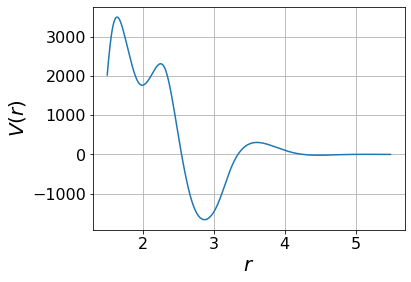

In [124]:
from uf3.jax.potentials import uf2_interaction

drs = jnp.arange(1.5,5.5,0.01)
U = uf2_interaction(drs, coefficients=params, knots=knots)
plt.plot(drs,U)
format_plot(r'$r$', r'$V(r)$')
finalize_plot()

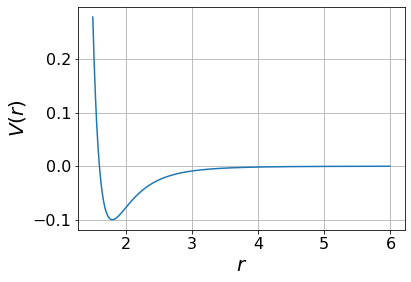

In [95]:
from jax_md.energy import lennard_jones

drs = jnp.arange(1.5,6.0,0.01)
U = lennard_jones(drs, sigma=1.6, epsilon=0.1)
plt.plot(drs,U)
format_plot(r'$r$', r'$V(r)$')
finalize_plot()